## Load Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## 1. Load the Dataset

In [2]:
# Load the dataset
file_path = "A.csv"  # Replace with the path to your dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

Dataset Preview:
         Date        Low       Open    Volume       High      Close  \
0  18-11-1999  28.612303  32.546494  62546380  35.765381  31.473534   
1  19-11-1999  28.478184  30.713518  15234146  30.758226  28.880545   
2  22-11-1999  28.657009  29.551144   6577870  31.473534  31.473534   
3  23-11-1999  28.612303  30.400572   5975611  31.205294  28.612303   
4  24-11-1999  28.612303  28.701717   4843231  29.998213  29.372318   

   Adjusted Close  
0       27.066582  
1       24.836662  
2       27.066582  
3       24.605980  
4       25.259573  


## 2. PreProcess the Dataset

### 2.1 Extract the Target Column

In [3]:
# Extract the "Close" column for prediction
close_prices = data['Close'].values

### 2.2 Scale the Data

In [4]:
# Scale the "Close" prices to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

### 2.3 Create Sequences

In [5]:
# Create sequences of 60 time steps to predict the next value
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(close_prices_scaled)):
    X.append(close_prices_scaled[i-sequence_length:i, 0])
    y.append(close_prices_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Print number of sequences created
print(f"Total sequences created: {len(X)}")
print(f"Shape of X: {X.shape} (num_sequences, sequence_length, num_features)")
print(f"Shape of y: {y.shape} (num_sequences, num_targets)")


Total sequences created: 5744
Shape of X: (5744, 60) (num_sequences, sequence_length, num_features)
Shape of y: (5744,) (num_sequences, num_targets)


### 2.4 Reshape for RNN Input

In [6]:
# Reshape X to match RNN input format (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


### 2.5 Split the Data into Training, Validation, and Testing Sets

In [7]:
# Split data into 80% training and 20% for testing
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print("Training, Validation, and Testing Data Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Training, Validation, and Testing Data Shapes:
X_train: (3676, 60, 1), y_train: (3676,)
X_val: (919, 60, 1), y_val: (919,)
X_test: (1149, 60, 1), y_test: (1149,)


## 3.Model Architecture and Training

### 3.1 Model 1 - RNN

In [8]:
# Build RNN model
rnn_model = Sequential([
    SimpleRNN(units=50, input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary
print("RNN Model Summary:")
rnn_model.summary()

RNN Model Summary:


C:\Users\21 Technology\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

### # Train RNN model

In [9]:
rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0029 - val_loss: 1.5093e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3965e-04 - val_loss: 1.1613e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0239e-04 - val_loss: 9.8740e-05
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2829e-04 - val_loss: 1.0035e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2250e-04 - val_loss: 8.0134e-05
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0493e-04 - val_loss: 8.3945e-05
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0622e-04 - val_loss: 1.2617e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0558e-04 - val_loss: 6.6564e-05
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4490e-05 - val_loss: 6.6946e-05
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7034e-05 - val_loss: 6.3494e-05
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step -

### Calculate Performance Metrics of Model-1

In [13]:
# Predict on the test set
y_pred_rnn = rnn_model.predict(X_test)

# Rescale predictions and true values to the original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rnn_original = scaler.inverse_transform(y_pred_rnn)

# Calculate MSE, RMSE, and Accuracy
mse = mean_squared_error(y_test_original, y_pred_rnn_original)
rmse = np.sqrt(mse)
accuracy = np.mean(np.sign(np.diff(y_test_original.flatten())) == np.sign(np.diff(y_pred_rnn_original.flatten()))) * 100
r2 = r2_score(y_test_original, y_pred_rnn_original)

# Display metrics
print("\nRNN Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"R²: {r2:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

RNN Model Performance Metrics:
MSE: 1.8370
RMSE: 1.3554
Accuracy: 99.48%
R²: 0.9987


### Predict and Rescale Data for the RNN Model

In [29]:
# Generate predictions for the training, validation, and test sets
train_predictions = rnn_model.predict(X_train)
val_predictions = rnn_model.predict(X_val)
test_predictions = rnn_model.predict(X_test)

# Rescale all predictions and true values to their original scale
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
train_predictions_original = scaler.inverse_transform(train_predictions)

y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1))
val_predictions_original = scaler.inverse_transform(val_predictions)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predictions_original = scaler.inverse_transform(test_predictions)

# Create indices for training, validation, and testing sets
train_indices = np.arange(len(y_train_original))
val_indices = np.arange(len(y_train_original), len(y_train_original) + len(y_val_original))
test_indices = np.arange(len(y_train_original) + len(y_val_original), len(y_train_original) + len(y_val_original) + len(y_test_original))



115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


### Plotting the RNN Model Predictions

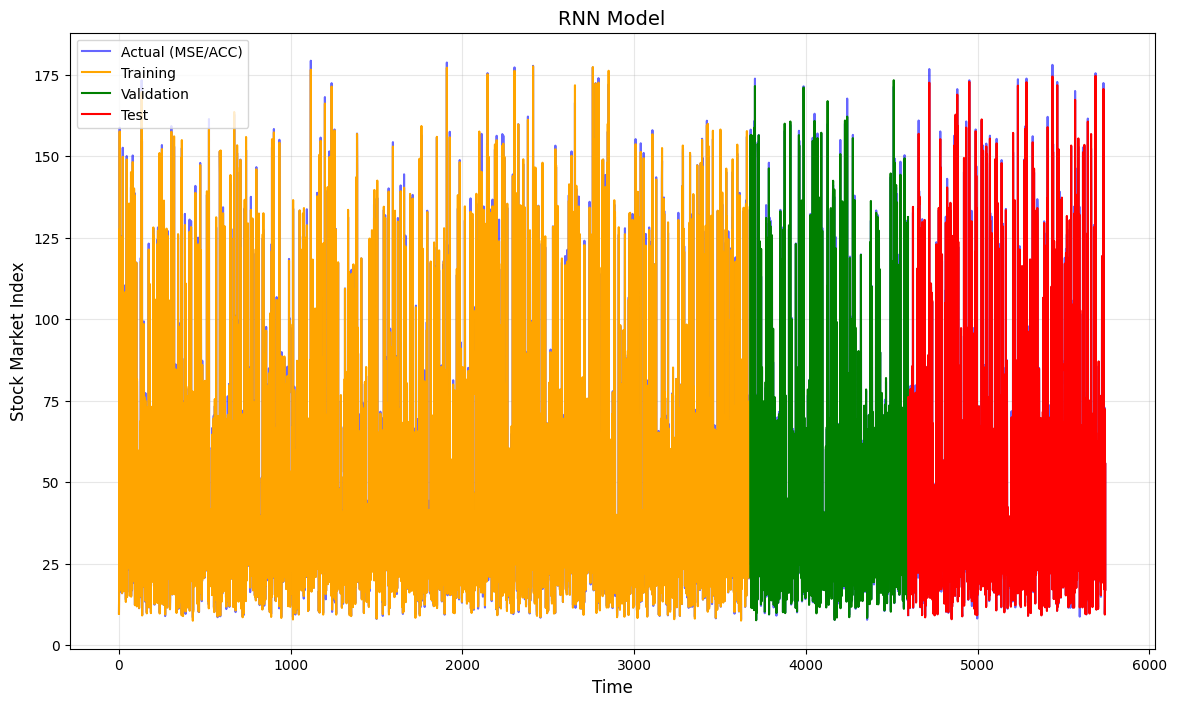

In [22]:
# Create the plot
plt.figure(figsize=(14, 8))

# Plot the actual values for all phases
plt.plot(train_indices, y_train_original, color='blue', alpha=0.6, label='Actual (MSE/ACC)')
plt.plot(val_indices, y_val_original, color='blue', alpha=0.6)
plt.plot(test_indices, y_test_original, color='blue', alpha=0.6)

# Plot the predicted values for each phase
plt.plot(train_indices, train_predictions_original, color='orange', label='Training')
plt.plot(val_indices, val_predictions_original, color='green', label='Validation')
plt.plot(test_indices, test_predictions_original, color='red', label='Test')

# Add titles, labels, and legend
plt.title("RNN Model", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Market Index", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.show()


## 3.2 Build the LSTM Model

In [25]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model summary
print("LSTM Model Summary:")
lstm_model.summary()

LSTM Model Summary:


C:\Users\21 Technology\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Train the LSTM Model

In [26]:
# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0417 - val_loss: 3.4917e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.8503e-04 - val_loss: 2.5626e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.0272e-04 - val_loss: 2.2506e-04
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.9539e-04 - val_loss: 2.1347e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1674e-04 - val_loss: 2.0134e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.7563e-04 - val_loss: 1.9477e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.4535e-04 - val_loss: 1.9090e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.0213e-04 - val_loss: 2.1364e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.1234e-04 - val_loss: 1.7003e-04
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.4642e-04 - val_loss: 2.3272e-04
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

### Calculate Performance Metrics of LSTM Model

In [27]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    accuracy = np.mean(np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten()))) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, accuracy, r2

# Evaluate the LSTM model on the test set
y_pred_test_lstm = lstm_model.predict(X_test)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_original = scaler.inverse_transform(y_pred_test_lstm)

# Calculate metrics
mse, rmse, accuracy, r2 = calculate_metrics(y_test_original, y_pred_test_original)

# Print metrics
print("\nLSTM Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"R²: {r2:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

LSTM Model Performance Metrics:
MSE: 6.0007
RMSE: 2.4496
Accuracy: 98.61%
R²: 0.9958


### Predict and Rescale Data for the LSTM Model

In [28]:
# Generate predictions for the training, validation, and test sets
train_predictions_lstm = lstm_model.predict(X_train)
val_predictions_lstm = lstm_model.predict(X_val)
test_predictions_lstm = lstm_model.predict(X_test)

# Rescale predictions and true values to their original scale
train_predictions_original = scaler.inverse_transform(train_predictions_lstm)
val_predictions_original = scaler.inverse_transform(val_predictions_lstm)
test_predictions_original = scaler.inverse_transform(test_predictions_lstm)

y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create indices for each phase
train_indices = np.arange(len(y_train_original))
val_indices = np.arange(len(y_train_original), len(y_train_original) + len(y_val_original))
test_indices = np.arange(len(y_train_original) + len(y_val_original), len(y_train_original) + len(y_val_original) + len(y_test_original))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


### Plotting the LSTM Model Predictions

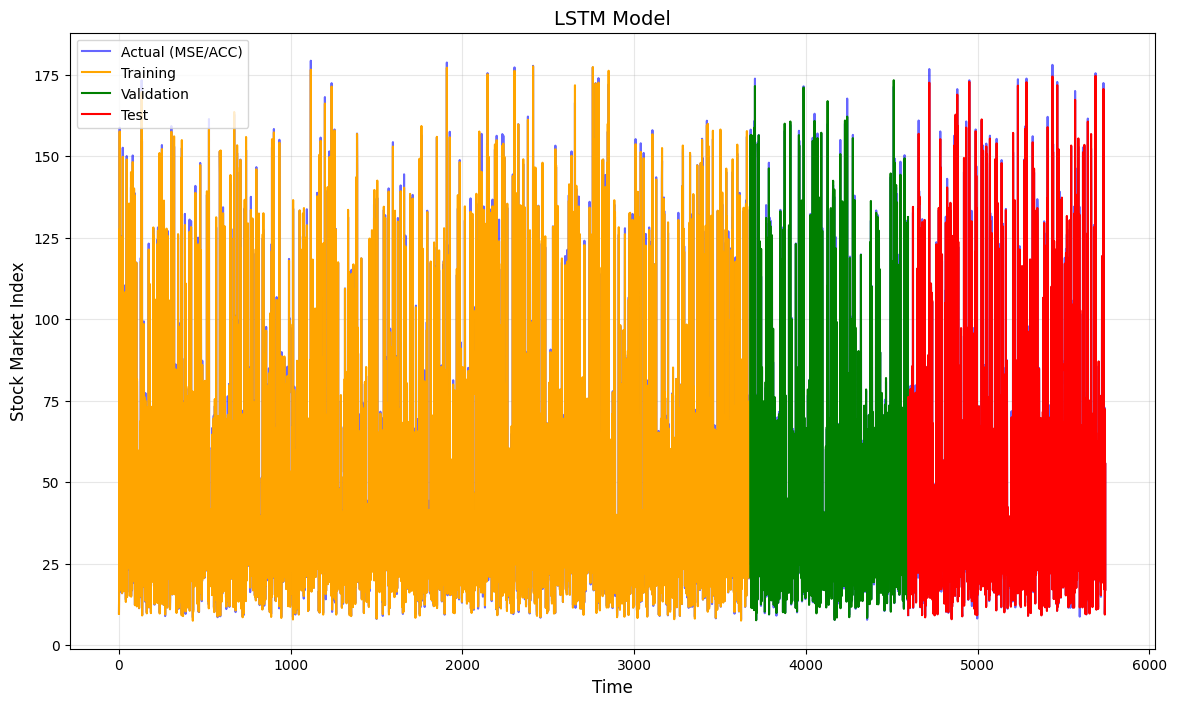

In [30]:
# Create the plot
plt.figure(figsize=(14, 8))

# Plot the actual values for all phases
plt.plot(train_indices, y_train_original, color='blue', alpha=0.6, label='Actual (MSE/ACC)')
plt.plot(val_indices, y_val_original, color='blue', alpha=0.6)
plt.plot(test_indices, y_test_original, color='blue', alpha=0.6)

# Plot the predicted values for each phase
plt.plot(train_indices, train_predictions_original, color='orange', label='Training')
plt.plot(val_indices, val_predictions_original, color='green', label='Validation')
plt.plot(test_indices, test_predictions_original, color='red', label='Test')

# Add titles, labels, and legend
plt.title("LSTM Model", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Market Index", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

## 3.3 Build the GRU Model

In [31]:
# Build the GRU model
gru_model = Sequential([
    GRU(units=50, input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model summary
print("GRU Model Summary:")
gru_model.summary()


GRU Model Summary:


C:\Users\21 Technology\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train the GRU Model

In [32]:
# Train the GRU model
history = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0648 - val_loss: 2.1989e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.0590e-04 - val_loss: 1.4800e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5767e-04 - val_loss: 1.2706e-04
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7113e-04 - val_loss: 1.2224e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4479e-04 - val_loss: 1.1155e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.2234e-04 - val_loss: 1.1136e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.3458e-04 - val_loss: 1.0006e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.1422e-04 - val_loss: 9.7463e-05
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.3652e-04 - val_loss: 9.3620e-05
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.1505e-04 - val_loss: 9.7795e-05
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step

### Calculate Performance Metrics of GRU Model

In [33]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    accuracy = np.mean(np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten()))) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, accuracy, r2

# Evaluate the GRU model on the test set
y_pred_test_gru = gru_model.predict(X_test)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_original = scaler.inverse_transform(y_pred_test_gru)

# Calculate metrics
mse, rmse, accuracy, r2 = calculate_metrics(y_test_original, y_pred_test_original)

# Print metrics
print("\nGRU Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"R²: {r2:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

GRU Model Performance Metrics:
MSE: 3.1846
RMSE: 1.7846
Accuracy: 98.87%
R²: 0.9978


### Predict and Rescale Data for the GRU Model

In [34]:
# Generate predictions for the training, validation, and test sets
train_predictions_gru = gru_model.predict(X_train)
val_predictions_gru = gru_model.predict(X_val)
test_predictions_gru = gru_model.predict(X_test)

# Rescale predictions and true values to their original scale
train_predictions_original = scaler.inverse_transform(train_predictions_gru)
val_predictions_original = scaler.inverse_transform(val_predictions_gru)
test_predictions_original = scaler.inverse_transform(test_predictions_gru)

y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create indices for each phase
train_indices = np.arange(len(y_train_original))
val_indices = np.arange(len(y_train_original), len(y_train_original) + len(y_val_original))
test_indices = np.arange(len(y_train_original) + len(y_val_original), len(y_train_original) + len(y_val_original) + len(y_test_original))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


### Plotting the GRU Model Predictions

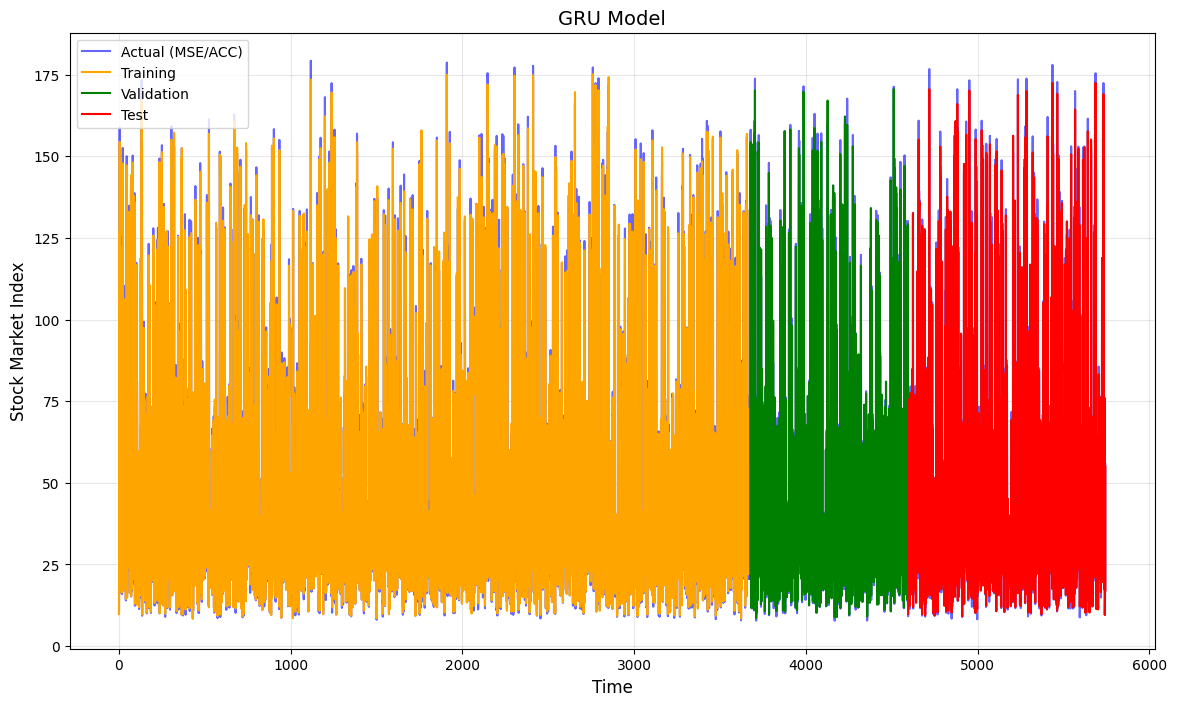

In [35]:
# Create the plot
plt.figure(figsize=(14, 8))

# Plot the actual values for all phases
plt.plot(train_indices, y_train_original, color='blue', alpha=0.6, label='Actual (MSE/ACC)')
plt.plot(val_indices, y_val_original, color='blue', alpha=0.6)
plt.plot(test_indices, y_test_original, color='blue', alpha=0.6)

# Plot the predicted values for each phase
plt.plot(train_indices, train_predictions_original, color='orange', label='Training')
plt.plot(val_indices, val_predictions_original, color='green', label='Validation')
plt.plot(test_indices, test_predictions_original, color='red', label='Test')

# Add titles, labels, and legend
plt.title("GRU Model", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Market Index", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

## 4. Comparison of Models

In [37]:
# Calculate RNN metrics
y_pred_test_rnn = rnn_model.predict(X_test)
y_pred_test_rnn_original = scaler.inverse_transform(y_pred_test_rnn)

mse_rnn, rmse_rnn, accuracy_rnn, r2_rnn = calculate_metrics(y_test_original, y_pred_test_rnn_original)

# Calculate LSTM metrics
y_pred_test_lstm = lstm_model.predict(X_test)
y_pred_test_lstm_original = scaler.inverse_transform(y_pred_test_lstm)

mse_lstm, rmse_lstm, accuracy_lstm, r2_lstm = calculate_metrics(y_test_original, y_pred_test_lstm_original)

# Calculate GRU metrics
y_pred_test_gru = gru_model.predict(X_test)
y_pred_test_gru_original = scaler.inverse_transform(y_pred_test_gru)

mse_gru, rmse_gru, accuracy_gru, r2_gru = calculate_metrics(y_test_original, y_pred_test_gru_original)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


### Create a Comparison Table

In [38]:
# Collect performance metrics for all three models
comparison_metrics = {
    "Metric": ["MSE", "RMSE", "Accuracy (%)", "R²"],
    "RNN": [mse_rnn, rmse_rnn, accuracy_rnn, r2_rnn],
    "LSTM": [mse_lstm, rmse_lstm, accuracy_lstm, r2_lstm],
    "GRU": [mse_gru, rmse_gru, accuracy_gru, r2_gru],
}

# Create a DataFrame for better visualization
comparison_table = pd.DataFrame(comparison_metrics)

# Display the comparison table
print("\nPerformance Comparison of RNN, LSTM, and GRU Models:")
print(comparison_table)



Performance Comparison of RNN, LSTM, and GRU Models:
         Metric        RNN       LSTM        GRU
0           MSE   1.836986   6.000650   3.184649
1          RMSE   1.355355   2.449622   1.784558
2  Accuracy (%)  99.477352  98.606272  98.867596
3            R²   0.998706   0.995773   0.997757


### Visualize the Comparison with a Bar Chart

<Figure size 1200x600 with 0 Axes>

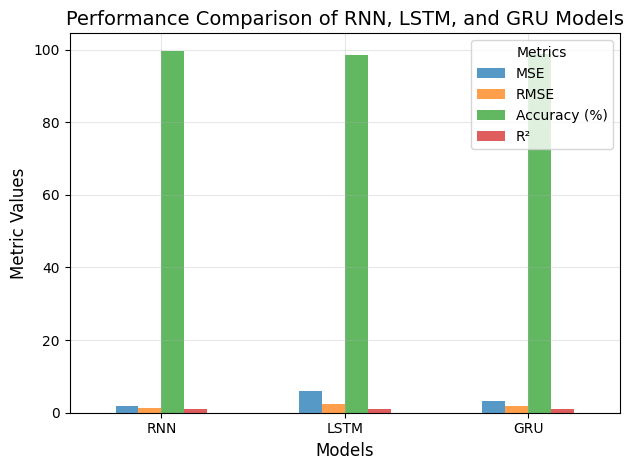

In [39]:
# Transpose the table for easier plotting
comparison_table_plot = comparison_table.set_index("Metric").T

# Plot the performance comparison
plt.figure(figsize=(12, 6))
comparison_table_plot.plot(kind="bar", alpha=0.75, rot=0)

# Add titles and labels
plt.title("Performance Comparison of RNN, LSTM, and GRU Models", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Metric Values", fontsize=12)
plt.legend(title="Metrics", fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
